In [2]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import missingno as mnso

import warnings
warnings.filterwarnings('ignore')

geo_path = 'data/seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'Malgun Gothic'

In [3]:
rental = pd.read_csv('data/서울특별시 공공자전거 대여소 정보.csv')
rental.head()

,대여소_구,대여소ID,대여소명,대여소주소,위도,경도,기준시작일자,거치대수
0,마포구,101.0,101. (구)합정동 주민센터,서울특별시 마포구 동교로8길 58,37.549561,126.905754,2015-09-06 23:40,5.0
1,마포구,102.0,102. 망원역 1번출구 앞,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2015-09-06 23:42,20.0
2,마포구,103.0,103. 망원역 2번출구 앞,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2015-09-06 23:43,14.0
3,마포구,104.0,104. 합정역 1번출구 앞,서울특별시 마포구 양화로 59,37.550629,126.914986,2015-09-06 23:44,13.0
4,마포구,105.0,105. 합정역 5번출구 앞,서울특별시 마포구 양화로 48,37.550007,126.914825,2015-09-06 23:45,5.0


In [4]:
rental.shape

(1541, 8)

In [5]:
rental.isnull().sum()

대여소_구     1
대여소ID     1
대여소명      1
대여소주소     1
위도        1
경도        1
기준시작일자    1
거치대수      1
dtype: int64

In [6]:
rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   대여소_구   1540 non-null   object 
 1   대여소ID   1540 non-null   float64
 2   대여소명    1540 non-null   object 
 3   대여소주소   1540 non-null   object 
 4   위도      1540 non-null   float64
 5   경도      1540 non-null   float64
 6   기준시작일자  1540 non-null   object 
 7   거치대수    1540 non-null   float64
dtypes: float64(4), object(4)
memory usage: 96.4+ KB


In [7]:
rental=rental.dropna(subset=['위도'])
rental=rental.dropna(subset=['경도'])
rental.shape

(1540, 8)

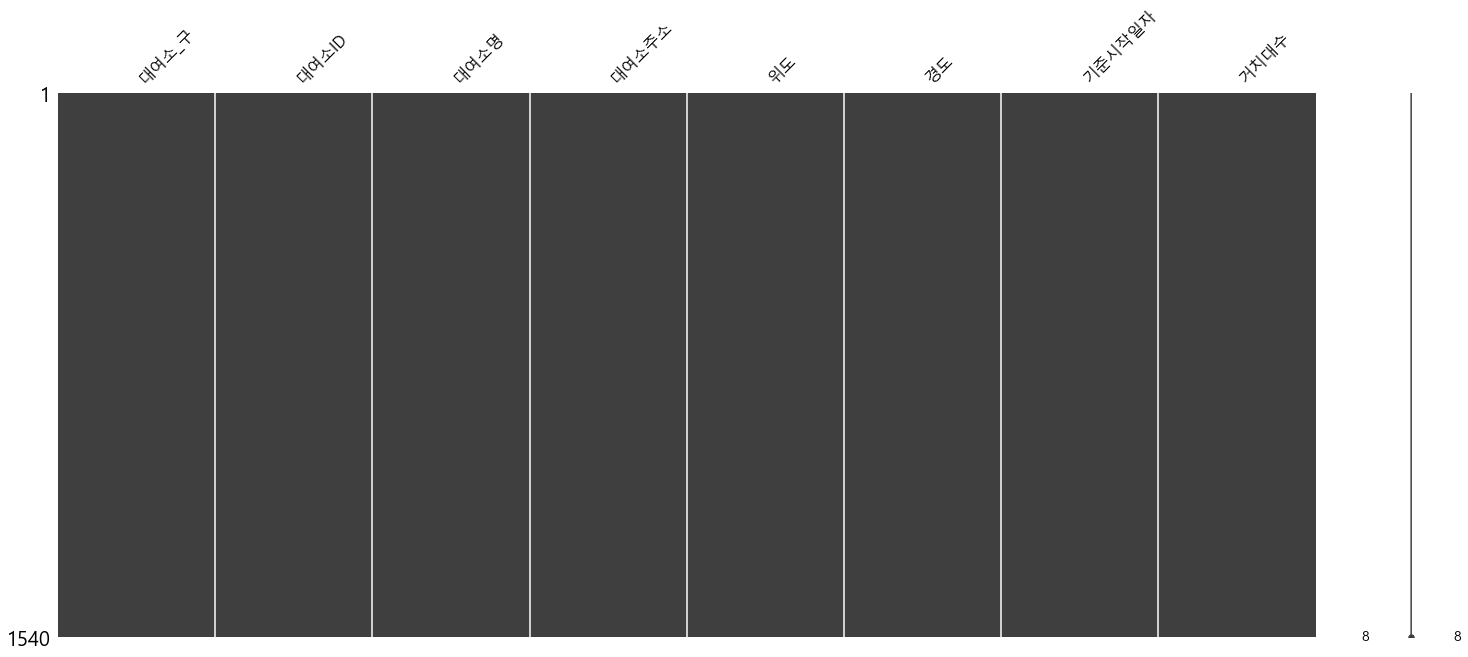

In [8]:
import missingno as msno

msno.matrix(rental)

In [9]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=11, tiles='CartoDB positron')
for i, row in rental.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        fill=True,
    ).add_to(bike_map)
bike_map

In [10]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
plugins.HeatMap(rental[['위도', '경도']].values.tolist(), radius=10, blur=5).add_to(bike_map)
plugins.Fullscreen(positions='topright').add_to(bike_map)
bike_map

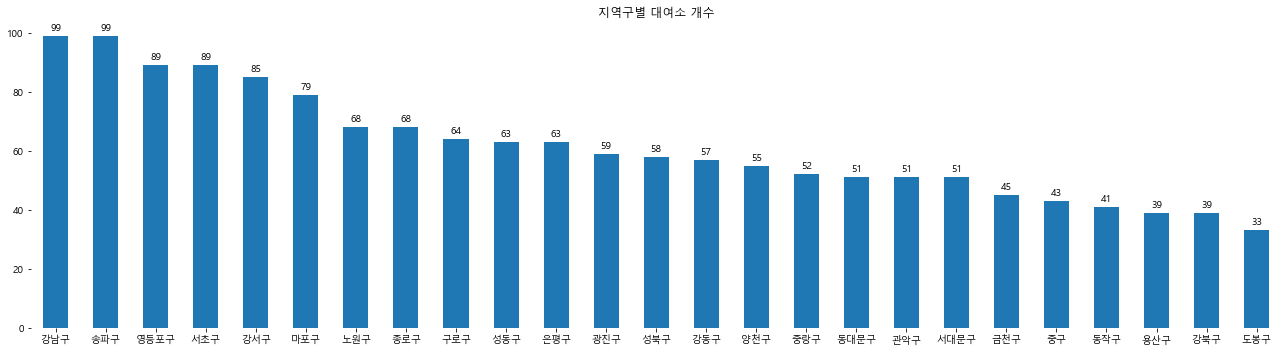

In [11]:
have_bikes = rental.groupby('대여소_구').size()
have_bikes.sort_values(ascending=False, inplace=True)

ax = have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 대여소 개수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

In [12]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=11, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
              data=have_bikes,
              key_on='feature.properties.name', 
              fill_color='Blues').add_to(bike_map)
bike_map

In [13]:
have_bikes_total = rental.groupby(['대여소_구'])[['거치대수']].agg('sum')
have_bikes_total

,거치대수
대여소_구,
강남구,1218.0
강동구,763.0
강북구,451.0
강서구,1002.0
관악구,640.0
광진구,841.0
구로구,788.0
금천구,560.0
노원구,879.0


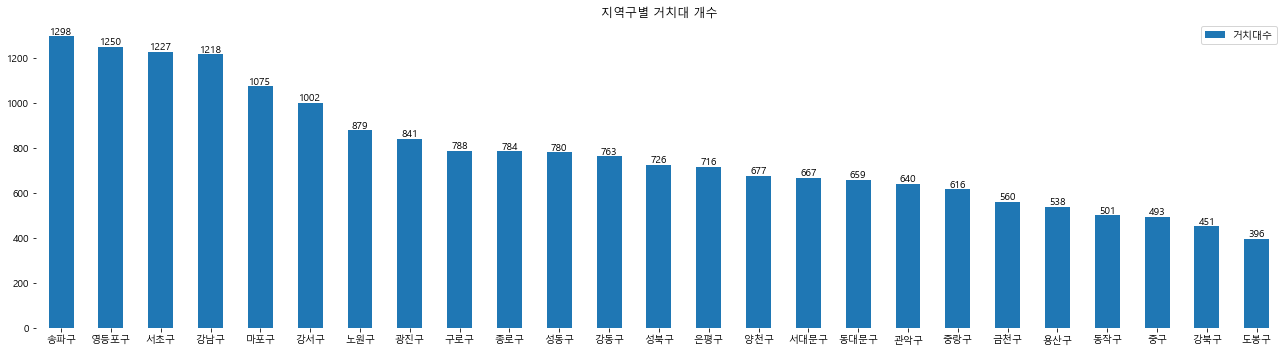

In [16]:
have_bikes_total_sort = have_bikes_total.sort_values(by=['거치대수'], axis=0, ascending=False)
ax = have_bikes_total_sort.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 거치대 개수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+10), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

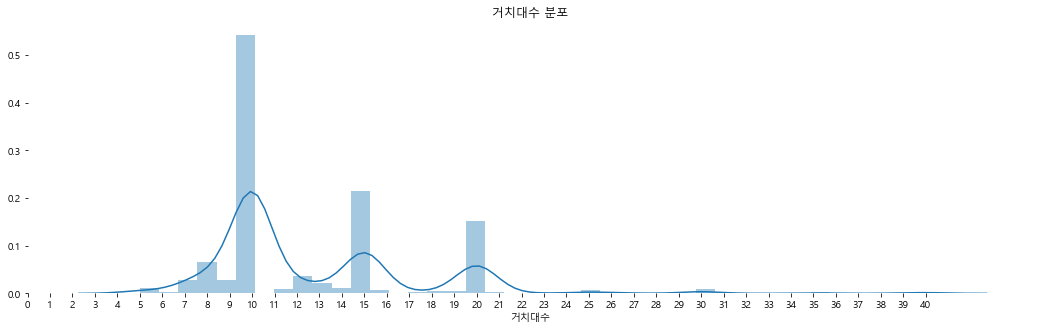

In [13]:
plt.figure(figsize=(18, 5))
sns.distplot(rental['거치대수'])
plt.title("거치대수 분포")
plt.xticks(range(0, 41))
plt.box(False)
plt.show()

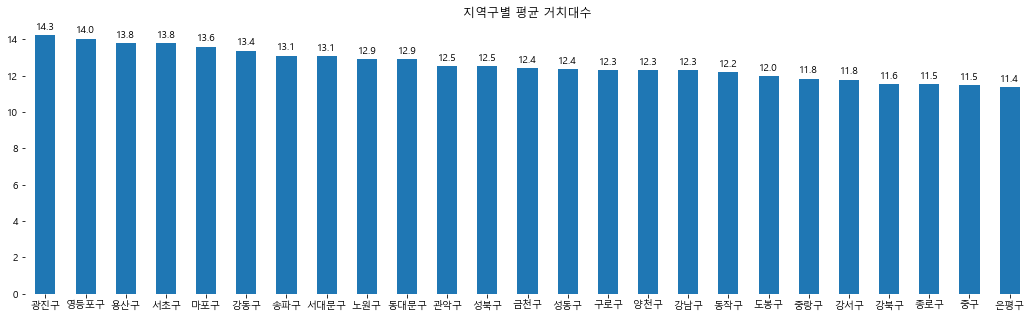

In [14]:
bike_rental = rental.groupby('대여소_구')['거치대수'].sum()
bike_rental = bike_rental / have_bikes
bike_rental.sort_values(ascending=False, inplace=True)

ax = bike_rental.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 평균 거치대수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%.1f"%(height), (left+width/2, height+0.3), ha='center')
plt.box(False)
plt.xlabel("")
plt.show()

In [15]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
                  data=bike_rental,
                  key_on='feature.properties.name', 
                  fill_color='Blues').add_to(bike_map)
bike_map